In [2]:
import os

# from sklearnex import patch_sklearn

# patch_sklearn()
from transformers import AutoTokenizer, AutoModel
import torch
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from IPython.utils import io
import matplotlib
import pandas as pd

from evaluation.dataset import PresidentsDataset
from evaluation.lists import PRESIDENTS, PRESIDENT_POLITICAL_PARTIES

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [2]:
def clean_and_embed_dataset(dataset_path: os.PathLike, model_name: str = "roberta-base", device: str = "cuda:0"):
    dataset = PresidentsDataset(path_to_data=dataset_path)

    # Grab just the documents in the presidential category and presidential speaker
    dataset.where(
        lambda data: "Presidential" in data["categories"]["primary"]
        and data["speaker"].lower() in PRESIDENTS
    )

    def thin_data(data):
        return {
            "slug": data["slug"],
            "political_party": PRESIDENT_POLITICAL_PARTIES[data["speaker"].lower()],
            "body": data["body"],
        }
    dataset.map(thin_data)

    try:
        tokenizer = AutoTokenizer.from_pretrained(model_name)
        model = AutoModel.from_pretrained(model_name)
        model.eval()
        model.to(device)

        tokenization_function = lambda strings: tokenizer(
            strings,
            padding=True,
            truncation=True,
            return_tensors="pt",
            max_length=512,
        )

        def embed_data(data):
            tokens = tokenization_function([data["body"]])
            tokens = {key: value.to(device) for key, value in tokens.items()}
            with torch.no_grad():
                output = model(**tokens)
                embedding = output.pooler_output[0].cpu().numpy()
                del output
            return {
                "slug": data["slug"],
                "political_party": data["political_party"],
                "embedding": embedding,
            }

        dataset.map(embed_data, verbose=True)
        del model, tokenizer
        
    except Exception as e:
        # Hugging face sucks at managing memory so
        # in the case of an exception we need to delete the model manually
        del model, tokenizer
        raise e

    return dataset

In [3]:
data_path = os.path.join("data", "parsed_documents")
dataset = clean_and_embed_dataset(data_path)

Loading data: 100%|██████████| 110015/110015 [00:22<00:00, 4903.35it/s]
Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Mapping: 100%|██████████| 80403/80403 [13:39<00:00, 98.06it/s] 


In [29]:
def make_and_save_scatter_plot(plot_locations, labels, legend_categories, title, save_path):
    # convert labels to int
    # labels = [legend_categories.index(label) for label in labels]
    df = pd.DataFrame(dict(x=plot_locations[:,0], y=plot_locations[:,1], label=labels))

    sns.set_style("darkgrid")
    fig = plt.figure(figsize=(15, 10))
    ax = fig.add_subplot(111)
    
    # color_list = sns.color_palette("viridis", len(legend_categories))
    color_list = sns.color_palette(n_colors=len(legend_categories))
    sns.scatterplot(
        data = df,
        x="x", 
        y="y", 
        hue="label", 
        ax=ax, 
        size=[5 for _ in range(len(labels))],
        legend= False, 
        palette=color_list,
    )
    ax.set_title(title)

    legend_handels = []
    for i, category in enumerate(legend_categories):
        legend_handels.append(matplotlib.patches.Patch(color= color_list[i], label=category))
    ax.legend(handles=legend_handels)

    # plt.savefig(save_path)
    plt.show()
    # plt.close()


def create_pca_plot(embeddings, labels, legend_categories, title_subject, save_path):
    pca = PCA(n_components=2)
    pca.fit(embeddings, labels)
    plot_locations = pca.transform(embeddings)

    make_and_save_scatter_plot(plot_locations, labels, legend_categories, f"PCA of {title_subject}", save_path + "/pca.jpg")

def create_tsne_plot(embeddings, labels, legend_categories, title_subject, save_path):
    with io.capture_output() as captured:
        tsne = TSNE(n_components=2, learning_rate='auto', perplexity=(len(embeddings)*.02))
        plot_locations = tsne.fit_transform(embeddings)

        make_and_save_scatter_plot(plot_locations, labels, legend_categories, f"TSNE of {title_subject}", save_path + "/tsne.jpg")

In [5]:
# Split dataset into embeddings and labels
embeddings = [data["embedding"] for data in dataset]
labels = [data["political_party"] for data in dataset]

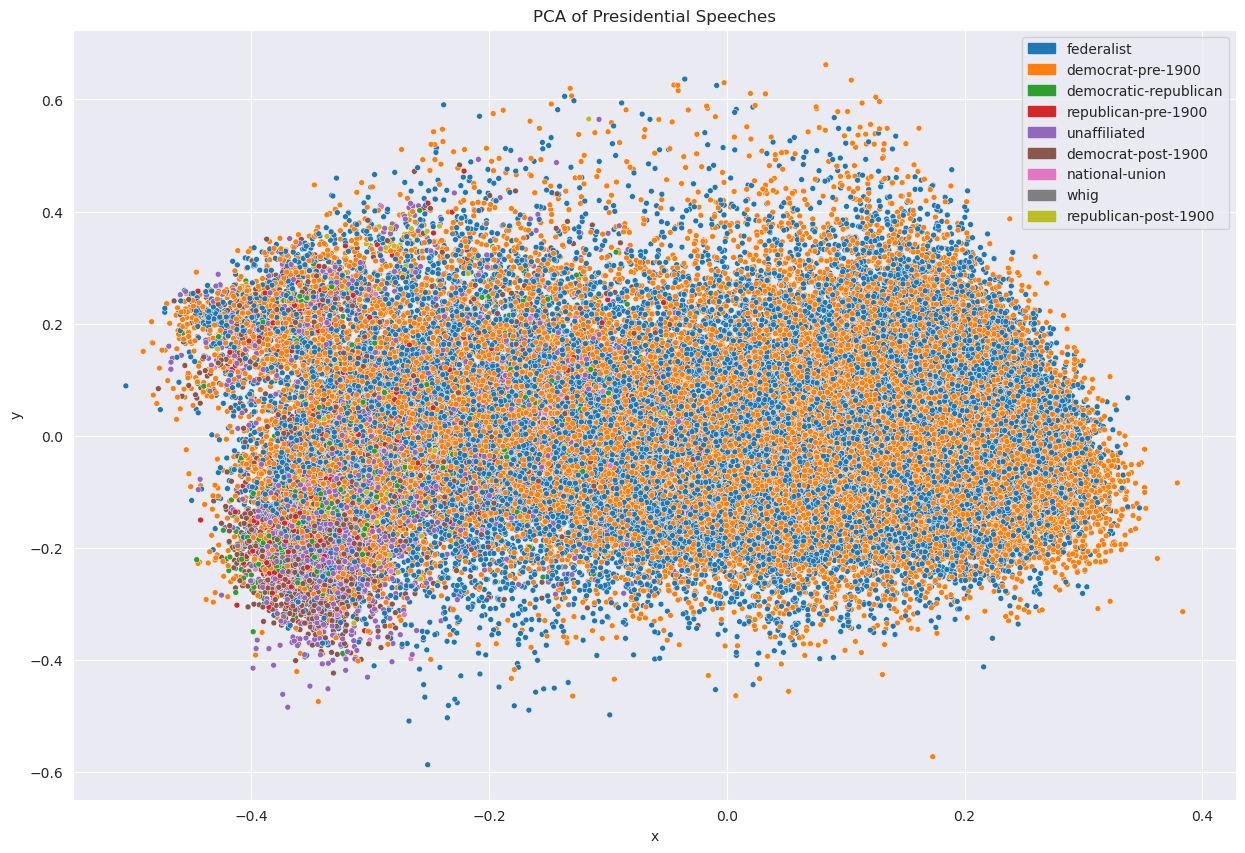

In [30]:
create_pca_plot(embeddings, labels, list(set(PRESIDENT_POLITICAL_PARTIES.values())), "Presidential Speeches", "presidential_speeches")

In [31]:
# filter out to just republican and democrat
limited_politic_embeddings = []
limited_politic_labels = []

for embedding, label in zip(embeddings, labels):
    if "republican-p" in label or "democrat-p" in label:
        limited_politic_embeddings.append(embedding)
        limited_politic_labels.append(label)

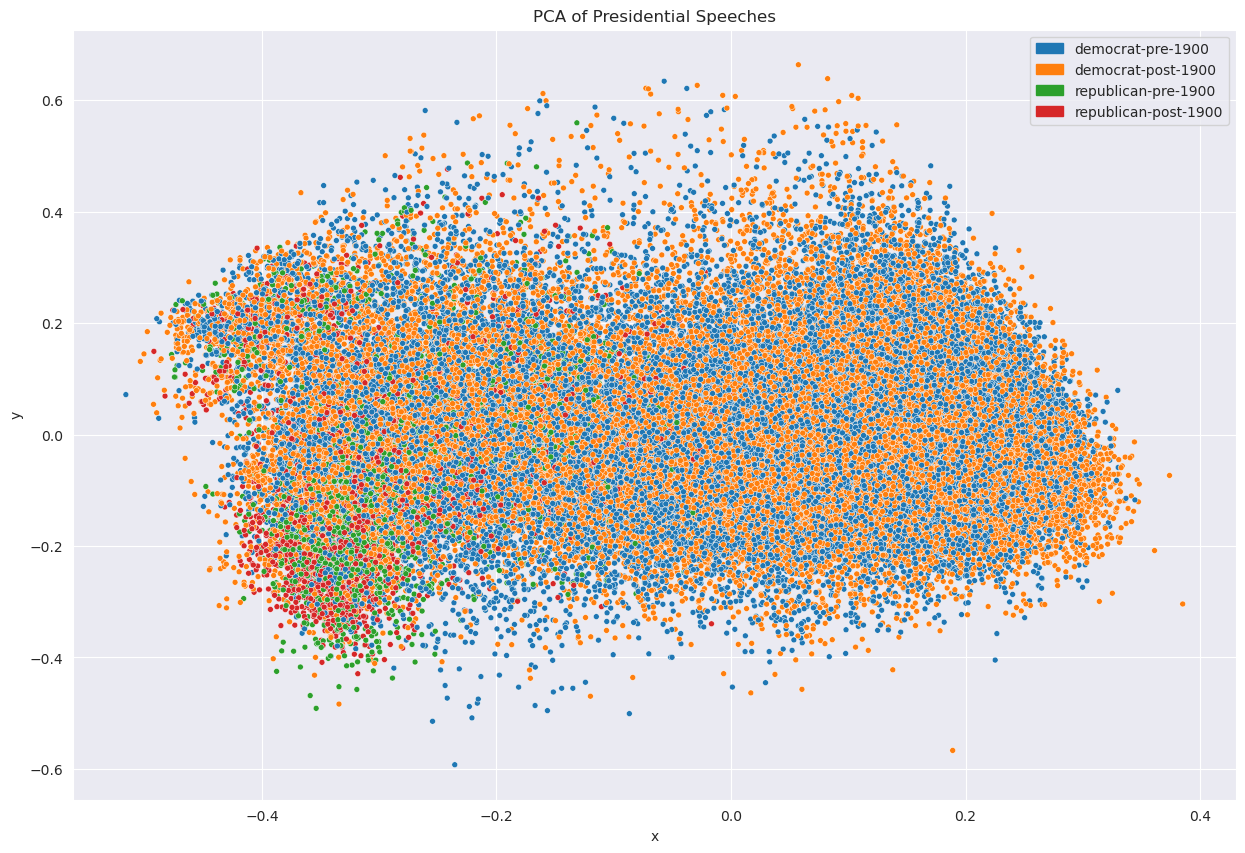

In [33]:
create_pca_plot(limited_politic_embeddings, limited_politic_labels, ["democrat-pre-1900", "democrat-post-1900", "republican-pre-1900", "republican-post-1900"], "Presidential Speeches", "presidential_speeches")

In [1]:
create_tsne_plot(torch.tensor(limited_politic_embeddings), limited_politic_labels, ["democrat-pre-1900", "democrat-post-1900", "republican-pre-1900", "republican-post-1900"], "Presidential Speeches", "presidential_speeches")

NameError: name 'create_tsne_plot' is not defined

/tmp/ipykernel_549996/3367834542.py:1: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /opt/conda/conda-bld/pytorch_1666642969563/work/torch/csrc/utils/tensor_new.cpp:230.)
  create_tsne_plot(torch.tensor(embeddings), labels, set(PRESIDENT_POLITICAL_PARTIES.values()), "Presidential Speeches", "presidential_speeches")


ValueError: Unable to parse string "republican-post-1900" at position 0

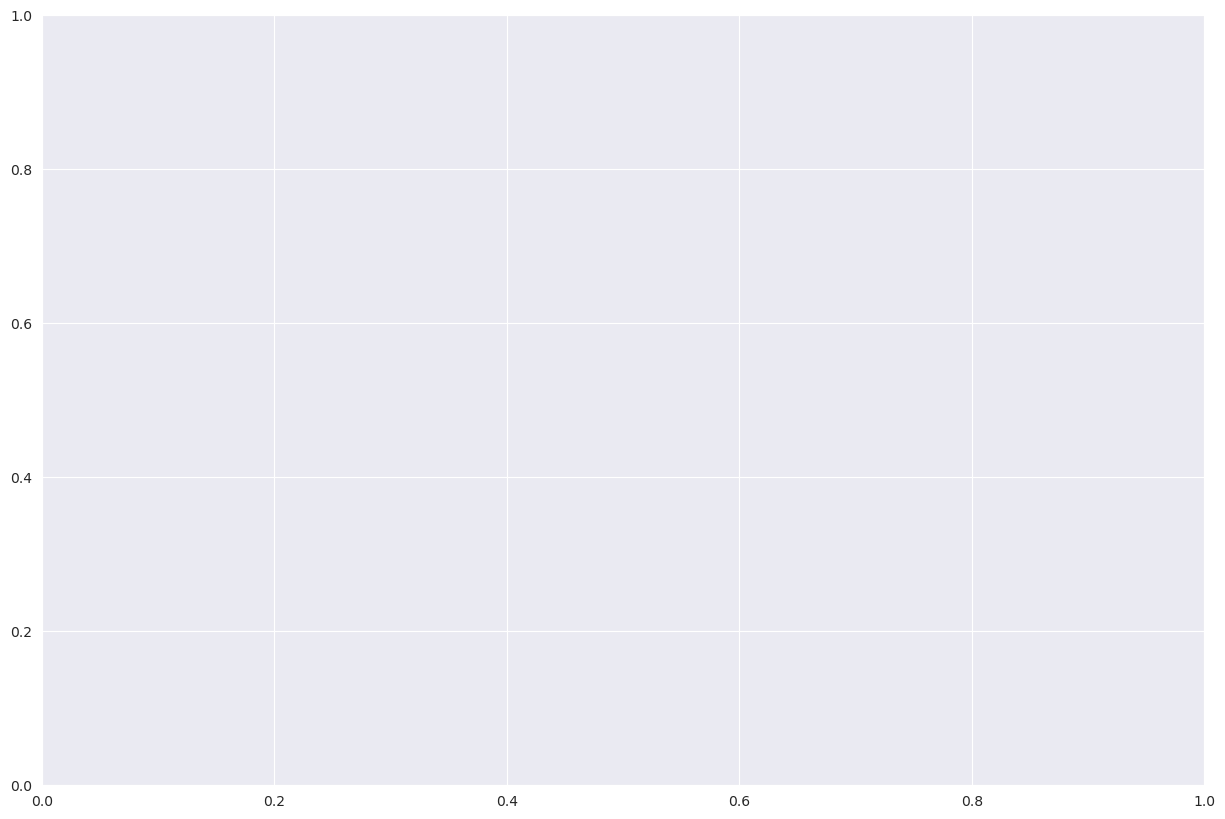

In [11]:
create_tsne_plot(torch.tensor(embeddings), labels, list(set(PRESIDENT_POLITICAL_PARTIES.values())), "Presidential Speeches", "presidential_speeches")